In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from pathlib import Path
from run_model import *
from models import *


In [7]:
train_path = Path("data/ath_bol_aar/simple_sf_nsnf_500_train.tsv")
val_path = Path("data/ath_bol_aar/simple_sf_nsnf_500_test.tsv")
test_path = Path("data/ath_bol_aar/simple_sf_nsnf_500_val.tsv")

train = pd.read_csv(train_path, sep="\t", header=0)
val = pd.read_csv(val_path, sep="\t", header=0)
test = pd.read_csv(test_path, sep="\t", header=0)

test.em_x = test.em_x.apply(eval)
test.em_y = test.em_y.apply(eval)

print(f"Training samples: {train.shape[0]},\t \t postive samples: {train.query('similar == True').shape[0]}")
print(f"Valdidation samples: {val.shape[0]},\t postive samples: {val.query('similar == True').shape[0]}")
print(f"Testing samples: {test.shape[0]},\t \t postive samples: {test.query('similar == True').shape[0]}")
print(f"Total samples: {train.shape[0] + val.shape[0] + test.shape[0]}, \t \t Postive samples: {train.query('similar == True').shape[0] + val.query('similar == True').shape[0] + test.query('similar == True').shape[0]}")


Training samples: 1241,	 	 postive samples: 617
Valdidation samples: 311,	 postive samples: 158
Testing samples: 666,	 	 postive samples: 334
Total samples: 2218, 	 	 Postive samples: 1109


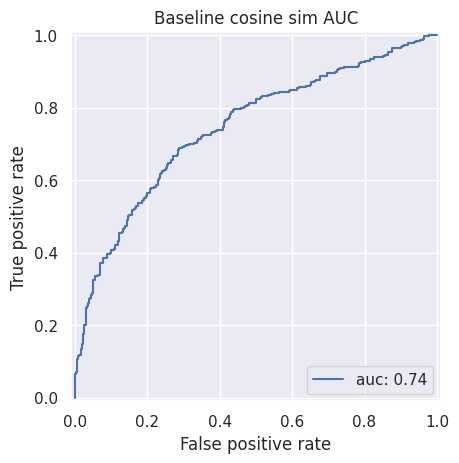

In [ ]:
def calc_cosine(r: pd.Series):
    em_x = r["em_x"]
    em_y = r["em_y"]
    return np.dot(em_x, em_y)/ (np.linalg.norm(em_x) * np.linalg.norm(em_y))

test["cosine_sim"] = test.apply(calc_cosine, axis=1)
viz = RocCurveDisplay.from_predictions(test["similar"].tolist(), test["cosine_sim"].tolist(), pos_label=True)
viz.ax_.set_title("Baseline cosine sim AUC")
viz.ax_.set_xlabel("False positive rate")
viz.ax_.set_ylabel("True positive rate")
viz.ax_.legend(labels=[f"auc: {round(viz.roc_auc, 2)}"], loc='lower right')
viz.figure_.savefig("results/poc/cosinesim_auc_val.png", dpi=300, bbox_inches="tight")

In [12]:
model_str = "small"
train_path = Path("data/ath_bol_aar/simple_sf_nsnf_500_train.tsv")
val_path = Path("data/ath_bol_aar/simple_sf_nsnf_500_test.tsv")
test_path = Path("data/ath_bol_aar/simple_sf_nsnf_500_val.tsv")
output_prefix = Path(f"results/poc/{model_str}")
checkpoint_path = Path(f"saved_models/poc/{model_str}")
batch_size = 128
epochs = 1000
validation = True
device = "cuda:0"

model_names = {"simple": simple_network,
               "small": small_network,
               "mini": mini_network}

In [ ]:


if model_str in model_names:
    model = model_names[model_str]
else: raise ValueError(f"cannot find model with name {model_str}")

print("Making train loader")
train_loader = make_dataloaders_old(train_path, batch_size)

print("Making test loader")
test_loader = make_dataloaders_old(test_path, batch_size)

model, history = train_model(model, epochs, train_loader, test_loader, checkpoint_path=checkpoint_path, verbose=False, device=device)


Making train loader


(1241, 6)
Making test loader
(666, 6)
new high! 0.6426426426426426
Epoch: 0, train a/l: 0.560/0.695 test a/l: 0.643/0.672
Epoch: 1, train a/l: 0.598/0.666 test a/l: 0.638/0.641
new high! 0.6546546546546547
Epoch: 2, train a/l: 0.589/0.657 test a/l: 0.655/0.641
new high! 0.6696696696696697
Epoch: 3, train a/l: 0.625/0.641 test a/l: 0.670/0.639
Epoch: 4, train a/l: 0.635/0.643 test a/l: 0.656/0.618
Epoch: 5, train a/l: 0.633/0.643 test a/l: 0.601/0.632
Epoch: 6, train a/l: 0.649/0.632 test a/l: 0.670/0.604
new high! 0.6756756756756757
Epoch: 7, train a/l: 0.645/0.635 test a/l: 0.676/0.624
Epoch: 8, train a/l: 0.658/0.621 test a/l: 0.664/0.602
new high! 0.6786786786786787
Epoch: 9, train a/l: 0.646/0.613 test a/l: 0.679/0.620
Epoch: 10, train a/l: 0.673/0.618 test a/l: 0.667/0.615
Epoch: 11, train a/l: 0.666/0.614 test a/l: 0.677/0.601
Epoch: 12, train a/l: 0.676/0.604 test a/l: 0.679/0.623
Epoch: 13, train a/l: 0.662/0.613 test a/l: 0.673/0.611
Epoch: 14, train a/l: 0.678/0.613 test a/l:

Making val loader
(311, 6)
validation Accuracy: 74.0%, Avg loss: 0.615044 



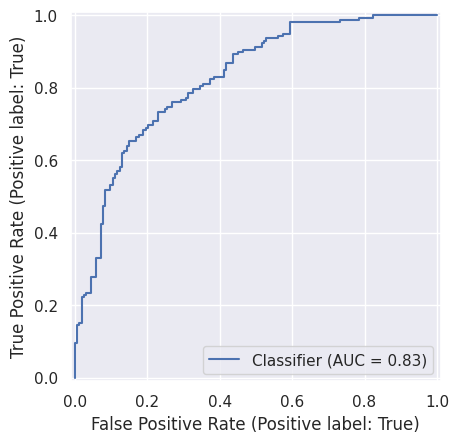

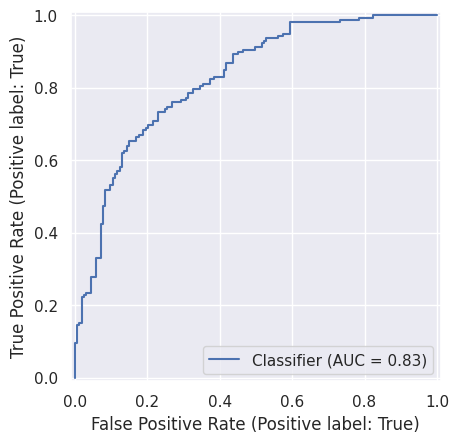

In [13]:
# plot_history(history, output_prefix)

model = model_names[model_str]

model = model().to("cuda:0")
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model.eval()

if validation:
    print("Making val loader")
    val_loader = make_dataloaders_old(val_path, batch_size)
    pred, labels = run_validation(model, val_loader, device=device)
    plot_auc(pred, labels, output_prefix)

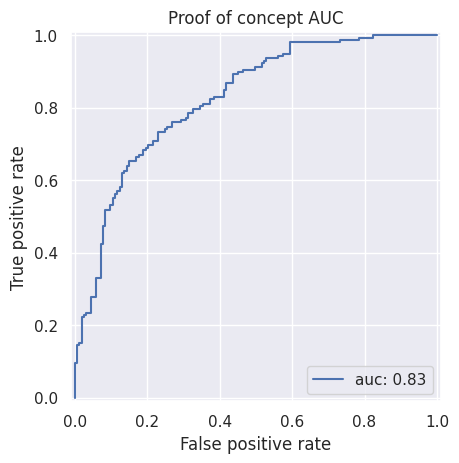

In [15]:
viz = RocCurveDisplay.from_predictions(labels, pred, pos_label=True, name="")

viz.ax_.set_title("Proof of concept AUC")
viz.ax_.set_xlabel("False positive rate")
viz.ax_.set_ylabel("True positive rate")
viz.ax_.legend(labels=[f"auc: {round(viz.roc_auc, 2)}"], loc='lower right')
viz.figure_.savefig(str(output_prefix)+"_auc_val.png", dpi=300, bbox_inches="tight")

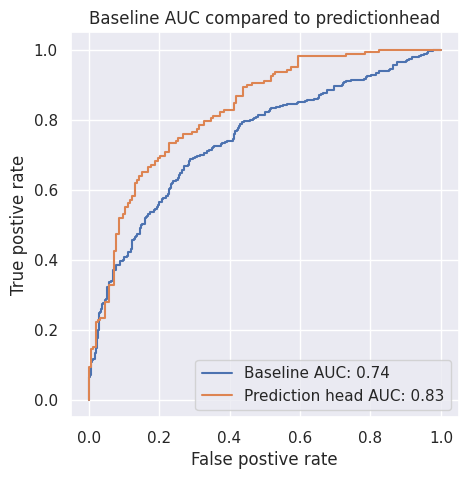

In [55]:
def calc_cosine(r: pd.Series):
    em_x = r["em_x"]
    em_y = r["em_y"]
    return np.dot(em_x, em_y)/ (np.linalg.norm(em_x) * np.linalg.norm(em_y))


test["cosine_sim"] = test.apply(calc_cosine, axis=1)
sns.set_theme(rc={'figure.figsize':(5,5)})

fpr, tpr, tresh = roc_curve(test["similar"].tolist(), test["cosine_sim"].tolist())
auc = roc_auc_score(test["similar"].tolist(), test["cosine_sim"].tolist())
plt.plot(fpr, tpr, label=f"Baseline AUC: {round(auc, 2)}")

fpr, tpr, tresh = roc_curve(labels, pred)
auc = roc_auc_score(labels, pred)
plt.plot(fpr, tpr, label=f"Prediction head AUC: {round(auc, 2)}")
plt.legend()
plt.title("Baseline AUC compared to predictionhead")
plt.xlabel("False postive rate")
plt.ylabel("True postive rate")
plt.savefig("results/poc/cosine_x_preditionhead_auc.png", dpi=300, bbox_inches="tight")
plt.show()
